# Tutorial 1: data integration for mouse spleen SPOTS

In this tutorial, we demonstrate how to apply SpatialGlue to integrate SPOTS (Chetrit et al.) data to decipher tissue heterogeity at a higher resolution. SPOTS enables the simultaneous measurements of spatial transcriptomics and protein profiling. As a example, we analyse a mouse spleen dataset. We downloaded the data from the GEO repository (accession no. GSE198353, https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE198353). According to marker genes and proteins, we manually annotated the tissue to 6 cell types, including T cell, B cell, RpMØ(red pulp macrophage), MZMØ(marginal zone macrophage ), and MMMØ(marginal metallophilic macrophages). Please refer to the results below for more details.

Before running the model, please download the input data via https://drive.google.com/drive/folders/1pV6u6U3JD8aTnBIGHEZdctZ0hZfWcBY1.

## Loading package

In [76]:
import os
import torch
import pandas as pd
import scanpy as sc

In [77]:
from SpatialGlue import SpatialGlue

In [78]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

# fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed=2022
fix_seed(random_seed)

In [79]:
# the number of clusters
n_clusters = 6

## Loading data

In [80]:
# read data
file_fold = '/home/yahui/anaconda3/work/SpatialGlue_omics/data/SPOTS/Mouse_Spleen/Replicate1/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_Pro.h5ad') 

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [81]:
adata_omics1

AnnData object with n_obs × n_vars = 2653 × 32285
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [82]:
adata_omics2

AnnData object with n_obs × n_vars = 2653 × 21
    obsm: 'spatial'

# Pre-processing data
After reading data of two omics modalities, SpatialGlue pre-processes the data as inputs of the model, including expression feature pre-processing and neighbor graph construction. More details can be found in the paper. (https://www.biorxiv.org/content/10.1101/2023.04.26.538404v2) 

The pre-processed features will be saved in adata_omics1.obsm['feat'] and adata_omics2.obsm['feat'] for modalities 1 and 2 respectively. 

In [83]:
from SpatialGlue.preprocess import preprocessing
data = preprocessing(adata_omics1, adata_omics2, datatype='SPOTS')

# Raw expression data analysis

In [84]:
from SpatialGlue.utils import clustering 

# clustering
clustering(adata_omics1, key='feat', add_key='RNA', n_clusters=6)
clustering(adata_omics2, key='feat', add_key='protein', n_clusters=6)

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [85]:
import numpy as np
# flip tissue image 
adata_omics1.obsm['spatial'] = np.rot90(np.rot90(np.rot90(np.array(adata_omics1.obsm['spatial'])).T).T).T
adata_omics1.obsm['spatial'][:,1] = -1*adata_omics1.obsm['spatial'][:,1]

adata_omics2.obsm['spatial'] = np.rot90(np.rot90(np.rot90(np.array(adata_omics2.obsm['spatial'])).T).T).T
adata_omics2.obsm['spatial'][:,1] = -1*adata_omics2.obsm['spatial'][:,1]

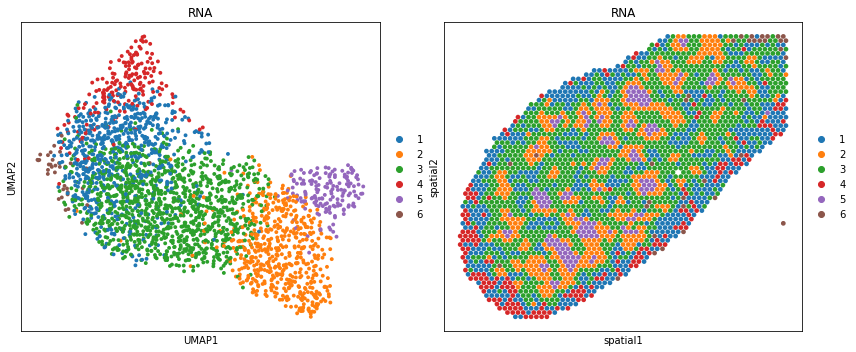

In [86]:
# visualization
import matplotlib.pyplot as plt

# mRNA
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_omics1, use_rep='feat', n_neighbors=10)
sc.tl.umap(adata_omics1)

sc.pl.umap(adata_omics1, color='RNA', ax=ax_list[0], title='RNA', s=60, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='RNA', ax=ax_list[1], title='RNA', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

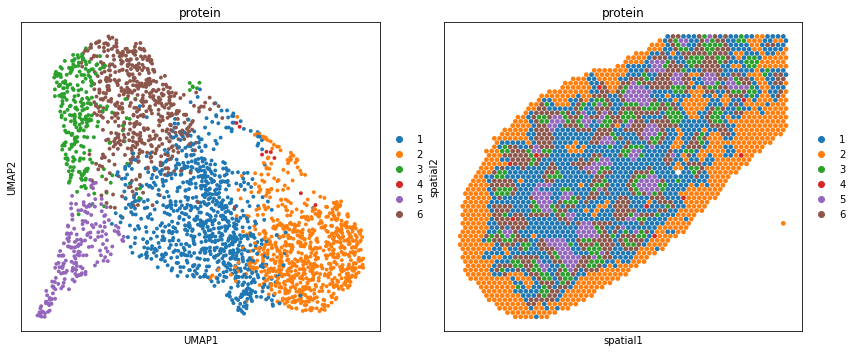

In [87]:
# protein
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_omics2, use_rep='feat', n_neighbors=10)
sc.tl.umap(adata_omics2)

sc.pl.umap(adata_omics2, color='protein', ax=ax_list[0], title='protein', s=60, show=False)
sc.pl.embedding(adata_omics2, basis='spatial', color='protein', ax=ax_list[1], title='protein', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

## Training the model

SpatialGlue model aims to learn an integrated latent representation by adaptively integrating expression profiles of different omics modalities in a spatially aware manner. 

After model training, SpatialGlue returns 'output' file. The 'output' file include multiple output results. Let's go through each of the results in more detail:

1. Latent Representations:

* 'emb_latent_omics1': This represents the modality-specific latent representation for the first omics modality.

* 'emb_latent_omics2': Similarly, this represents the modality-specific latent representation for the second omics modality.

* 'emb_combined': This represents the integrated latent representation that combines expression features and spatial information from both omics modalities. It provides a joint representation that captures the cross-omics information in a spatially aware manner.

   The integrated representation can be used as feature vectors for downstream analysis tasks such as clustering, visualization, or identifying differentially expressed genes (DEGs).

2. Attention Weight Values:

* 'alpha_omics1': This attention weight value represents the within-modality attention weight for the first omics modality. It indicates the importance of each neighbor graph within the same modality.

* 'alpha_omics2': Similarly, this attention weight value represents the within-modality attention weight for the second omics modality.

* 'alpha': This attention weight value represents the between-modality attention weight. It indicates the importance of each modalities to each cell type.

   These attention weight values provide insights into the importance of the neighborhood graph or modality for each cell type. They can help identify which modalities or neighbor graphs are more crucial for specific cell types, guiding further analysis and interpretation of the results.

In [88]:
# define model
model = SpatialGlue.SpatialGlue(data, epochs=900, device=device)

# train model
output = model.train()

  0%|                                                                                                                                                                                                                                                    | 0/900 [00:00<?, ?it/s]/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/SpatialGlue/model.py:167: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Model training finished!



In [89]:
output.keys()

dict_keys(['emb_latent_omics1', 'emb_latent_omics2', 'emb_latent_combined', 'alpha_omics1', 'alpha_omics2', 'alpha'])

In [90]:
adata_combined = adata_omics1.copy()
adata_combined.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata_combined.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata_combined.obsm['emb_latent_combined'] = output['emb_latent_combined']

## Cross-omics integrative analysis

After integration, we perform clustering analysis using the integrated representation. Here we provid three optional kinds of tools for spaital clustering, including mclust, leiden, and louvain. In our experiment, we find mclust performs better than leiden and louvain on spatial data in most cases. Therefore, we recommend using mclust.

In [91]:
# we use mcluster as clustering tool by default.
tool = 'mclust' # mclust, leiden, and louvain

# performing PCA
adata_combined.obsm['emb_combined_pca'] = sc.tl.pca(adata_combined.obsm['emb_latent_combined'], n_comps=20)

# clustering
if tool == 'mclust':
   clustering(adata_combined, key='emb_combined_pca', add_key='SpatialGlue', n_clusters=6, method=tool) 
elif tool in ['leiden', 'louvain']:
   clustering(adata_combined, key='emb_combined_pca', add_key='SpatialGlue', n_clusters=6, method=tool, start=0.1, end=2.0, increment=0.01) 

fitting ...
  |======================================================================| 100%


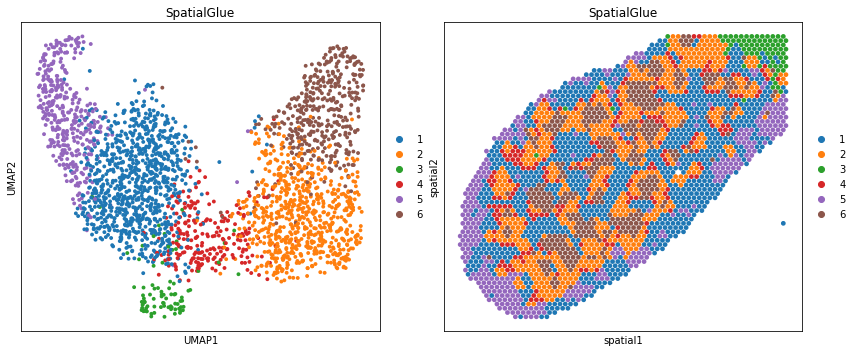

In [92]:
# visualization
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_combined, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [93]:
# annotation
# 'MZMØ' represents marginal zone macrophage, 'MMMØ' represents marginal metallophilic macrophages, 'RpMØ' represents red pulp macrophage
adata_combined.obs['SpatialGlue'].cat.rename_categories({1: 'MZMØ',
                                                   2: 'B cell',
                                                   3: 'Epithelia',
                                                   4: 'MMMØ',
                                                   5: 'RpMØ',
                                                   6: 'T cell'}, inplace=True)

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [94]:
# reorder
import pandas as pd
list_ = ['MZMØ','MMMØ','RpMØ','B cell', 'T cell','Epithelia']
adata_combined.obs['SpatialGlue']  = pd.Categorical(adata_combined.obs['SpatialGlue'], 
                      categories=list_,
                      ordered=True)

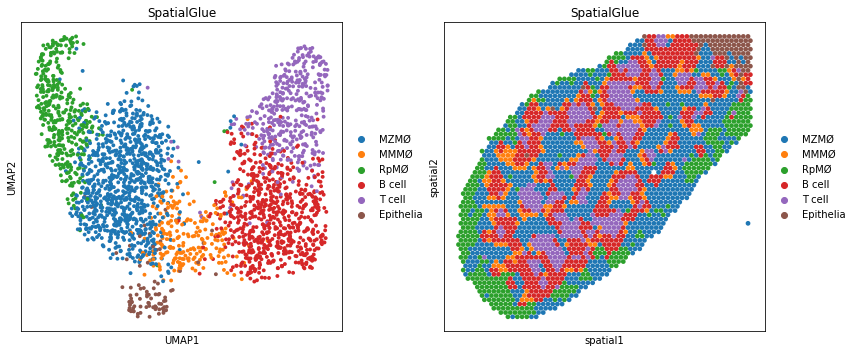

In [95]:
# plotting with annotation
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

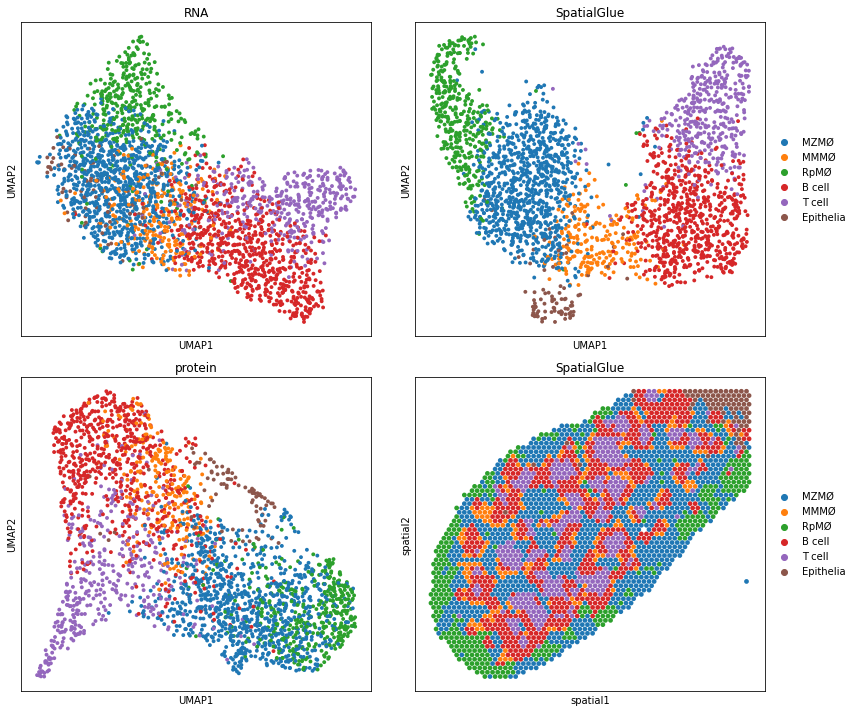

In [96]:
# joint plotting of raw and integrated data colored by SpatialGlue's lable
fig, ax_list = plt.subplots(2, 2, figsize=(12, 10))

adata_omics1.obs['SpatialGlue'] = adata_combined.obs['SpatialGlue'].copy()
adata_omics2.obs['SpatialGlue'] = adata_combined.obs['SpatialGlue'].copy()

sc.pl.umap(adata_omics1, color='SpatialGlue', ax=ax_list[0, 0], title='RNA', s=60, show=False)
sc.pl.umap(adata_omics2, color='SpatialGlue', ax=ax_list[1, 0], title='protein', s=60, show=False)

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0, 1], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1, 1], title='SpatialGlue', s=90, show=False)

ax_list[0, 0].get_legend().remove()
ax_list[1, 0].get_legend().remove()

plt.tight_layout(w_pad=3)
plt.show()

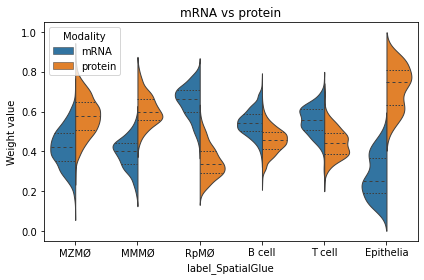

In [97]:
# plotting modality weight values
# To visualize the weight values of different modalities, we provide 'plot_weight_value' function. 
from SpatialGlue.utils import plot_weight_value
plot_weight_value(output['alpha'], adata_combined.obs['SpatialGlue'].values)